# <center>Convex Optimization - Homework 3
### <center> Léonard Hussenot

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

## 1) Interior Points Method

Defining $\phi_t$, its gradiant and hessian

In [14]:
def phi(x,t,Q,p,A,b):
    mat_temp = b - np.dot(A,x)
    if np.min(mat_temp) > 0:
        res= t * (1/2 * np.dot(x, np.dot(Q,x)) + np.dot(p,x)) - np.sum(np.log(mat_temp))
        return res
    else:
        return np.infty

In [15]:
def grad(x,t,Q,p,A,b):
    mat = b-np.dot(A, x)
    
    res = t*(np.dot(Q,x) + p) + np.dot(A.T,1/mat)
    return res


In [16]:
def hess(x,t,Q,p,A,b):
    mat = b-np.dot(A, x)
     
    res = t*Q + np.dot(
                    A.T,
                    np.dot(np.diag(1/mat**2),A)
                   )
    
    return res

## 2) Newton Method

In [17]:
def dampedNewtonStep(x,f,g,h):
    grd = g(x)
    hss = h(x)
    inv = np.linalg.inv(hss)

    dx = np.dot(inv, grd)
    
    lamb_2 = np.dot(grd, dx)

    x_new = x - 1/(1+np.sqrt(lamb_2)) * dx
    return x_new, 0.5*(lamb_2)

In [34]:
# tol should be inferior to (3-np.sqrt(5))*0.5 ~ 0.38...

def dampedNewton(x0,f,g,h,tol):
    gaps = []
    x = x0
    xhist = [x0]
    keep_going = True
    while keep_going:
        x, gap = dampedNewtonStep(x,f,g,h)
        xhist.append(np.copy(x))
        keep_going = gap > tol
        gaps.append(gap)
    return x, xhist

In [19]:
beta = 0.7
alpha = 0.48

def newtonLS(x0,f,g,h,tol):
    x = x0
    gaps = []
    xhist = [x0]
    keep_going = True
    while keep_going:

        grd = g(x)
        hss = h(x)

        inv = np.linalg.inv(hss)
        dx = -np.dot(inv, grd)

        tlocal = 1
        lamb_2 = -np.dot(grd, dx)
        
        ok = True
        while ok :
            try:
                ok =  f(x + tlocal*dx) > f(x) - alpha*tlocal*(lamb_2)
            except:
                ok = True
            tlocal *= beta

        x += tlocal*dx

        xhist.append(np.copy(x))
        gaps.append(0.5*lamb_2)
        
        keep_going = 0.5*lamb_2 > tol
        
    return x, xhist


## 3) Support Vector Machine Problem

In [20]:
def transform_svm_primal(tau,X,y):
    n, d = X.shape
    
    # What's going to play the role of the x we optimize is the concatenated vector of w and z
    Q = np.diag([1  if i<d else 0 for i in range(d+n)])
    p = np.array([0 if i<d else 1/(tau*n) for i in range(d+n)])
    
    # A1 describe the first inegality
    A1 = - np.concatenate((X*(y.reshape(n,1)),np.eye(n)),1)
    
    # A2 describe the second inegality (z>0)
    A2 = - np.concatenate((np.zeros_like(X),np.eye(n)),1)
    A = np.concatenate((A1, A2), 0)
    
    b = - np.concatenate((np.ones(n),np.zeros(n)))
    return Q, p, A, b



In [21]:
def transform_svm_dual(tau,X,y):
    n, d = X.shape
    D = X*(y.reshape((len(y),1)))
    Q = np.dot(D,D.T)
    p = -np.ones(n)
    
    A = np.eye(n)
    b = 1/(tau*n)*np.ones(n)
    return Q, p, A, b

In [50]:
# Also returns the duality gap over the iterations

def barr_method(Q,Q_d,p,A,b,x_0,mu,tol, method="DNS"):
    # Assert x0 feasible
    n = len(b)
    assert(np.sum(np.dot(A,x_0)<=b) == n)
    x = np.copy(x_0)
    xhist_total = []
    t = 1
    gaps = []
    while n/t > tol:
        f = lambda xx: phi(xx,t,Q,p,A,b)
        g = lambda xx: grad (xx,t,Q,p,A,b)
        h = lambda xx: hess (xx,t,Q,p,A,b)
        
        if method == "DNS":
            x, xhist = dampedNewton(x,f,g,h,tol)
        else:
            x, xhist = newtonLS(x,f,g,h,tol)
        
        # Log Barrier -> we can thus derive the corresponding approximation for the Lagrange multiplier
        lambda_star_tot = -1/t * 1/(np.dot(A,x)-b)
        lambda_star = lambda_star_tot[:n/2]
        #In fact, after recomputing by hand the dual, I realized the lambda we talk about is only the first 
        # half of the all lambda (which has dimension 2*n as there is 2*n constraints in the primal)

        dual = np.sum(lambda_star)-1/2*np.dot(
            np.dot(lambda_star,Q_d), lambda_star)
        primal = 1/2*np.dot(np.dot(x,Q),x) + np.dot(p,x)
        
        gap = primal - dual
        for k in range(len(xhist)):
            gaps.append(gap)
        xhist_total += xhist
        t *= mu
    return x, xhist_total, gaps

## Testing on Iris Dataset

In [42]:
# Don't forget to modify the relative path if needed!

data = pd.read_csv("data/iris.data", header=None)
data = data[(data[4]=='Iris-versicolor') | (data[4]=='Iris-virginica')]
data[4][data[4]=='Iris-versicolor'] = 1
data[4][data[4]=='Iris-virginica'] = -1
data = data.values

np.random.shuffle(data)


In [45]:
def test_on_iris_dataset(data, mu=20, tau = 0.001, method='DNS'):
    
    #Separating Train set and Test set
    sep = int(len(data)/5)
    data_test = data[:sep]
    data_train = data[sep:]

    y = np.array(data_train[:,4],dtype='float')
    X = np.array(data_train[:,:4],dtype='float')
    X = X - np.mean(X,0)

    tol = 0.001


    w0 = np.zeros_like(X[0,:])
    z0 = 2 * np.ones_like(y)
    #stricly feasible x_0 ;  x is the concatenation of w and z  (and has a shape n+d)
    x_0 = np.concatenate((w0,z0))

    #compute the primal
    Q, p, A, b = transform_svm_primal(tau,X,y)
    
    #compute the primal
    Q_d, p_d, A_d, b_d = transform_svm_dual(tau,X,y)

    # Solve the primal
    x_sol, xhist, _ = barr_method(Q,Q_d,p,A,b,x_0,mu,tol, method=method)

    w = x_sol[:4]
    z = x_sol[4:]

    #test on Test set
    y_test = np.array(data_test[:,4],dtype='float')
    X_test = np.array(data_test[:,:4],dtype='float')
    X_test = X_test - np.mean(X_test,0)

    y_pred = np.sign(np.dot(X_test,w))
    print("tau = {}  => Test-Error = {} %".format(
                                            tau,
                                            np.round(
                                                        100*(
                                                            1 - np.sum(y_pred==y_test)/len(y_pred)
                                                            )
                                            ))
     )

In [49]:
#testing
print("----------------------------------------------")
print("------- Learning on 80% of the dataset -------")
print("---------------- mu = 20 ---------------------")
print()
print("- with Damped Newton Step")
for tau in [1,0.5,0.2,0.1,0.001,0.0001]:
    test_on_iris_dataset(data, tau=tau, method="DNS")
print("----------------------------------------------")
print()
print("- with Backtracking Line Search")
for tau in [1,0.5,0.2,0.1,0.001,0.0001]:
    test_on_iris_dataset(data, tau=tau, method="BLS")
print("----------------------------------------------")
print("----------------------------------------------")

----------------------------------------------
------- Learning on 80% of the dataset -------
---------------- mu = 20 ---------------------

- with Damped Newton Step
tau = 1  => Test-Error = 5.0 %
tau = 0.5  => Test-Error = 5.0 %
tau = 0.2  => Test-Error = 5.0 %
tau = 0.1  => Test-Error = 10.0 %
tau = 0.001  => Test-Error = 5.0 %
tau = 0.0001  => Test-Error = 15.0 %
----------------------------------------------

- with Backtracking Line Search
tau = 1  => Test-Error = 5.0 %
tau = 0.5  => Test-Error = 5.0 %
tau = 0.2  => Test-Error = 5.0 %
tau = 0.1  => Test-Error = 10.0 %
tau = 0.001  => Test-Error = 5.0 %
tau = 0.0001  => Test-Error = 15.0 %
----------------------------------------------
----------------------------------------------


A too small $\tau$ leads to an overfitting on the data and thus a greater test error.
With a too high $\tau$, we have don't fit correctly the data

## Plotting the duality gap for the two methods and differents values of $\mu$

In [26]:
gapmu = []
for method in ["DNS", "BLS"]:
    for mu in [2,15,50,100]:
        y = np.array(data[:,4],dtype='float')
        X = np.array(data[:,:4],dtype='float')
        X = X - np.mean(X,0)

        tau = 0.002 #regularization parameter
        tol = 0.01

        w0 = np.zeros_like(X[0,:])
        z0 = 2 * np.ones_like(y)
        #stricly feasible x_0 ;  x is the concatenation of w and z  (and has a shape n+d)
        x_0_p = np.concatenate((w0,z0))

        #For the dual : stricly feasible x_0 ;  x is the lambda vector (and has a shape n)
        x_0_d = np.ones(len(y))/(2*tau*len(y))

        #compute the primal
        Q_p, p_p, A_p, b_p = transform_svm_primal(tau,X,y)

        #compute the dual
        Q_d, p_d, A_d, b_d = transform_svm_dual(tau,X,y)

        # Solve them with history of the x's
        x_p, xhist_p, gaps = barr_method(Q_p, Q_d, p_p, A_p, b_p, x_0_p, mu, tol, method=method)
        gapmu.append(gaps)

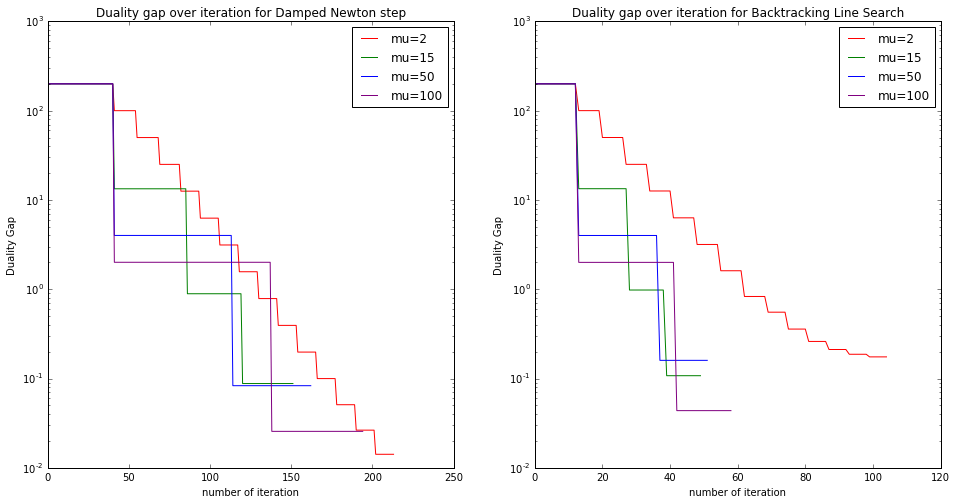

In [33]:
plt.figure(figsize=(16,8))
colors = ['red','green','blue','purple']
labels = ["mu=2","mu=15","mu=50","mu=100"]
plt.subplot(1,2,1)
for i in range(4):
    plt.semilogy(range(len(gapmu[i])),gapmu[i], color=colors[i],label=labels[i])
plt.xlabel('number of iteration')
plt.ylabel('Duality Gap')
plt.title('Duality gap over iteration for Damped Newton step')
plt.legend()

plt.subplot(1,2,2)
for i in range(4,8):
    plt.semilogy(range(len(gapmu[i])),gapmu[i], color=colors[i-4], label=labels[i-4])
plt.xlabel('number of iteration')
plt.ylabel('Duality Gap')
plt.title('Duality gap over iteration for Backtracking Line Search',fontsize=12)
plt.legend()

plt.show()

By increasing $\mu$, fewer calls to the inner loop are made, mais the inner loop has more iterations to do.
Algorithm seems to converge in much fewer interations with Backtracking Line Search, (60 agains 150 with $\mu=15$)